In [1]:
import os
import collections
import json
import torch
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import glob

import PIL
from PIL import Image
from tqdm.notebook import tqdm
from torch.utils import data
from torchvision import transforms

In [2]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

In [3]:
class VOC2012_Dataset(data.Dataset):
    n_classes = 21
    means = [0.485, 0.456, 0.406]
    stds  = [0.229, 0.224, 0.225]
    
    def __init__(self, root, img_size=(512,512)):
        self.root = root
        self.img_size = img_size
        self.train_val_names = self.read_names(f'{self.root}/ImageSets/Segmentation/trainval.txt')
        self.img_paths   = [f'{self.root}/JPEGImages/{name}.jpg' for name in self.train_val_names]
        self.label_paths = [f'{self.root}/EncodedSegMap/{name}.png' for name in self.train_val_names]
        if len(glob.glob(f'{self.root}/EncodedSegMap/*.png')) != len(self.label_paths):
            src_paths = [f'{self.root}/SegmentationClass/{name}.png' for name in self.train_val_names]
            self.pre_encode_segmap(src_paths, self.label_paths)
            
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(self.means, self.stds),
            ]
        )
    
    def __len__(self):
        return len(self.label_paths)
    
    def __getitem__(self, index):
        img = Image.open(self.img_paths[index])
        label = Image.open(self.label_paths[index])
        return self.transform_img_label(img, label)
    
    @staticmethod
    def get_pascal_labels():
        """Load the mapping that associates pascal classes with label colors
        Returns:
            np.ndarray with dimensions (21, 3)
        """
        return np.asarray(
            [
                [0, 0, 0],
                [128, 0, 0],
                [0, 128, 0],
                [128, 128, 0],
                [0, 0, 128],
                [128, 0, 128],
                [0, 128, 128],
                [128, 128, 128],
                [64, 0, 0],
                [192, 0, 0],
                [64, 128, 0],
                [192, 128, 0],
                [64, 0, 128],
                [192, 0, 128],
                [64, 128, 128],
                [192, 128, 128],
                [0, 64, 0],
                [128, 64, 0],
                [0, 192, 0],
                [128, 192, 0],
                [0, 64, 128],
            ]
        )
    
    @staticmethod
    def encode_segmap(mask):
        """Encode segmentation label images as pascal classes
        Args:
            mask (np.ndarray): raw segmentation label image of dimension
              (M, N, 3), in which the Pascal classes are encoded as colours.
        Returns:
            (np.ndarray): class map with dimensions (M,N), where the value at
            a given location is the integer denoting the class index.
        """
        mask = mask.astype(int)
        label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int16)
        for ii, label in enumerate(VOC2012_Dataset.get_pascal_labels()):
            label_mask[np.where(np.all(mask == label, axis=-1))[:2]] = ii
        label_mask = label_mask.astype(int)
        return label_mask
    
    @staticmethod
    def decode_segmap(label_mask):
        """Decode segmentation class labels into a color image
        Args:
            label_mask (np.ndarray): an (M,N) array of integer values denoting
              the class label at each spatial location.
            plot (bool, optional): whether to show the resulting color image
              in a figure.
        Returns:
            (np.ndarray, optional): the resulting decoded color image.
        """
        label_colours = VOC2012_Dataset.get_pascal_labels()
        r = label_mask.copy()
        g = label_mask.copy()
        b = label_mask.copy()
        for ll in range(0, VOC2012_Dataset.n_classes):
            r[label_mask == ll] = label_colours[ll, 0]
            g[label_mask == ll] = label_colours[ll, 1]
            b[label_mask == ll] = label_colours[ll, 2]
        rgb = np.zeros((label_mask.shape[0], label_mask.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        return rgb
    
    @staticmethod
    def denormalize(tensor):
        return UnNormalize(mean=VOC2012_Dataset.means, std=VOC2012_Dataset.stds)(tensor)
    
    def read_names(self, names_path):
        names = []
        with open(names_path) as f:
            lines = f.readlines()
            for line in lines:
                names.append(''.join(line.split()))
        return names
    
    def pre_encode_segmap(self, src_paths, dst_paths):
        os.makedirs(os.path.dirname(dst_paths[0]), exist_ok=True)
        pbar = tqdm(total = len(src_paths))
        for src_path, dst_path in zip(src_paths, dst_paths):
            label = np.asarray(Image.open(src_path).convert('RGB'))
            encoded_label = VOC2012_Dataset.encode_segmap(label)
            encoded_label = Image.fromarray(encoded_label)
            encoded_label.save(dst_path, format="png")
            pbar.update()
        pbar.close()
            
    def transform_img_label(self, img, label):
        img = self.transform(img.resize(self.img_size))
        label = np.array(label.resize(self.img_size, Image.NEAREST))
        label = torch.from_numpy(label).long()
        label[label==255] = 0
        return img, label

In [4]:
train_data = VOC2012_Dataset(root="G:/Codes/RealTime-Segementation/datasets/VOC2012")
train_dataloader = data.DataLoader(train_data, batch_size=16, shuffle=True)

(512, 512)


torch.Size([16, 512, 512]) tensor(0) tensor(20)
(512, 512, 3) 0.0 1.0
(512, 512, 3) 0.0 0.7529411764705882


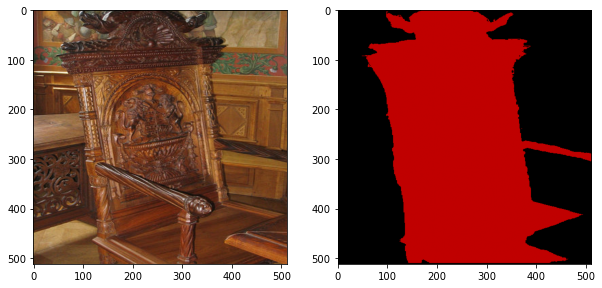

In [5]:
for i, (img, label) in enumerate(train_dataloader):
    img = VOC2012_Dataset.denormalize(img[0]).numpy().transpose([1,2,0])
    print(label.shape, label.min(), label.max())
    label = VOC2012_Dataset.decode_segmap(label.numpy()[0])
    print(img.shape, img.min(), img.max())
    print(label.shape, label.min(), label.max())
    plt.figure(figsize=(10,10))
    plt.subplot(121), plt.imshow(img)
    plt.subplot(122), plt.imshow(label)
    plt.show()
    break